In [1]:
import os
import numpy as np
import random

from common.loading import load_training_validation_data, load_test_data, create_generator, get_steps_per_epoch
from common.losses import monitor_mae, monitor_mse, ssim_eucli_loss
from common.testing import get_counts, predict_counts, get_mae_rmse, save_test_results, plot_prediction
from common.training import prepare_output_dirs, create_weights_callbacks, create_tensorboard_callback, create_early_stopping_callback, read_history, plot_losses, save_losses
from common.utils import get_flops, print_flops
from datetime import datetime
from importlib import reload
from models import SANetDS
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Settings
dataset = "B"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
SEED = 31415
np.random.seed(SEED)
random.seed(SEED)

Using TensorFlow backend.


## Training data loading

In [2]:
train_img, train_labels, validation_img, validation_labels = load_training_validation_data(dataset)

Loaded training images
Loaded training density maps
Loaded validation images
Loaded validation density maps


## Model definition (DS:Conv 3:1)

In [13]:
# Model definition

reload(SANetDS)

epochs = 200
batch_size = 5
model_name = 'sanet'
submodel_name = '3_1'


weights_val_path = os.path.join('weights', f'{model_name}_{submodel_name}_{dataset}_val.hdf5')
weights_train_path = os.path.join('weights', f'{model_name}_{submodel_name}_{dataset}_train.hdf5')
res_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{model_name}_{submodel_name}"

callbacks = [
    *create_weights_callbacks(weights_train_path, weights_val_path),
    create_tensorboard_callback(),
    create_early_stopping_callback()
]

custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse, 'ssim_eucli_loss': ssim_eucli_loss}

model = SANetDS.SANetDS(ds_to_conv=(3, 1), enable_in=False)
model.summary()
model._get_distribution_strategy = lambda: None
adam = Adam()

# ssim_eucli_loss or 'mean_squared_error'
model.compile(loss=ssim_eucli_loss, optimizer=adam,
              metrics=[monitor_mae, monitor_mse])

Model: "SANet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, None, None, 4 8           input_3[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_60 (SeparableC (None, None, None, 1 25          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, None, None, 4 40          input_3[0][0]                    
______________________________________________________________________________________________

## Training (DS:Conv 3:1)

In [14]:
prepare_output_dirs()

In [15]:
#model = load_model('D:\\inzynierka\\inzynierka\\weights\\sanet_3_1_B_train.hdf5', custom_objects=custom_objects)

def fit(model, epochs=epochs):
    history = model.fit(
        x=create_generator(train_img, train_labels, batch_size),
        steps_per_epoch=get_steps_per_epoch(train_img, train_labels, batch_size),
        epochs=epochs,
        validation_data=create_generator(validation_img, validation_labels, 1),
        validation_steps=get_steps_per_epoch(validation_img, validation_labels, 1),
        callbacks=callbacks
    )
    return history

modules_first_layer_indices = [1, 11, 27, 43, 58]  # 
last_index = 77
assert last_index == len(model.layers)
modules_indices = modules_first_layer_indices + [last_index]

for i in range(len(modules_indices) - 1):
    for j in range(modules_indices[1], modules_indices[i]):
        model.layers[j].trainable = False
    for j in range(modules_indices[i], modules_indices[i+1]):
        model.layers[j].trainable = True
    for j in range(modules_indices[i+1], modules_indices[-1]):
        model.layers[j].trainable = False

    model.compile(loss=ssim_eucli_loss, optimizer=adam, metrics=[monitor_mae, monitor_mse])

    fit(model, 2)  # 10

for i in range(1, modules_indices[-1]):
    model.layers[i].trainable = True

model.compile(loss=ssim_eucli_loss, optimizer=adam, metrics=[monitor_mae, monitor_mse])
history = fit(model)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 720 steps, validate for 400 steps
Epoch 1/2
719/720 [============================>.] - ETA: 0s - loss: 5.3661e-06 - monitor_mae: 31.3561 - monitor_mse: 0.2111
Epoch 00001: val_loss improved from inf to 0.00000, saving model to weights\sanet_3_1_B_val.hdf5

Epoch 00001: loss improved from inf to 0.00001, saving model to weights\sanet_3_1_B_train.hdf5
720/720 [==============================] - 135s 188ms/step - loss: 5.3668e-06 - monitor_mae: 31.3651 - monitor_mse: 0.2111 - val_loss: 3.9881e-06 - val_monitor_mae: 5.0991 - val_monitor_mse: 0.0296
Epoch 2/2
719/720 [============================>.] - ETA: 0s - loss: 5.3510e-06 - monitor_mae: 33.4842 - monitor_mse: 0.2106
Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to weights\sanet_3_1_B_val.hdf5

Epoch 00002: loss improved from 0.00001 to 0.00001, saving model to weights\sanet_3_1_B_train.hdf5
720/720 [==============================] - 129s 179ms/step - los

D:\Programy\Conda\envs\mmnet-win\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
D:\Programy\Conda\envs\mmnet-win\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,monitor_mae,monitor_mse
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


KeyboardInterrupt: 

## Analyze training (DS:Conv 3:1)

In [ ]:
loss, val_loss = read_history(history)
plot_losses(loss, val_loss)
save_losses(loss, val_loss, res_name)
print(res_name)

## Test data loading

In [6]:
test_img, test_labels = load_test_data(dataset)

Loaded test images
Loaded test density maps


## Test (DS:Conv 3:1)

In [19]:
def test_model(train_or_val):
    weights_path = eval(f'weights_{train_or_val}_path')

    model = load_model(weights_path, custom_objects=custom_objects)

    targets = get_counts(test_labels)
    predictions = predict_counts(model, test_img)

    mae, rmse = get_mae_rmse(targets, predictions)

    save_test_results(model, mae, rmse, res_name, train_or_val, weights_path)

    print(res_name + ' ' + train_or_val)
    print(f'MAE: {mae}, RMSE: {rmse}')

test_model('train')
test_model('val')

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:21<00:00,  3.87it/s]


2020-11-07_13-45-46_sanet_3_1 train
MAE: 69.2048457061188, RMSE: 109.14285412345653


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:21<00:00,  3.87it/s]

2020-11-07_13-45-46_sanet_3_1 val
MAE: 69.2048457061188, RMSE: 109.14285412345653


## Results presentation (DS:Conv 3:1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


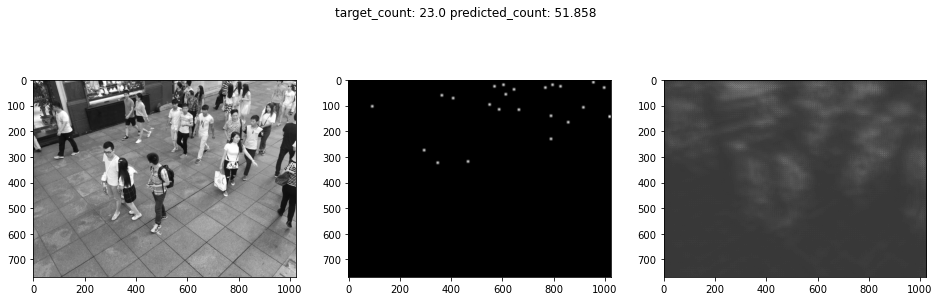

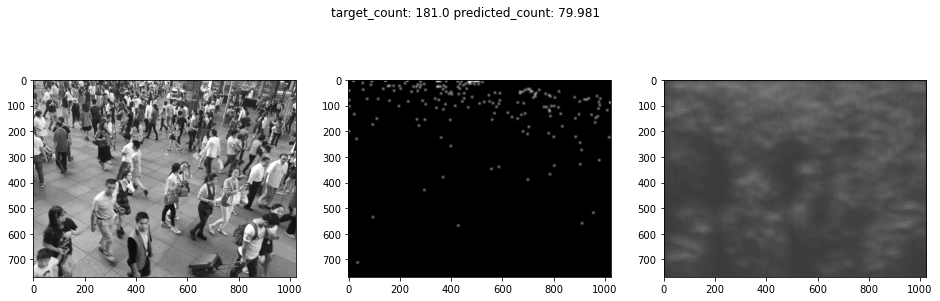

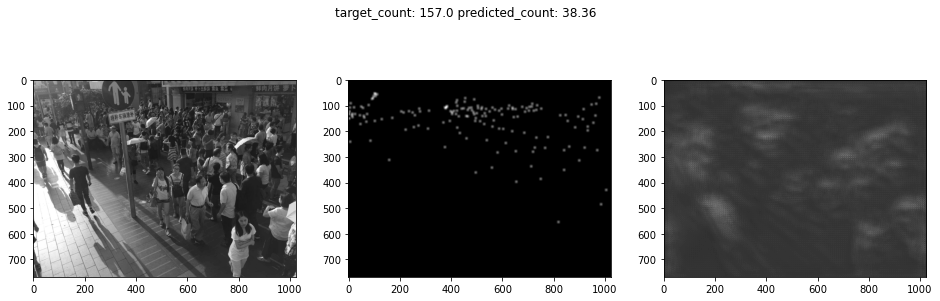

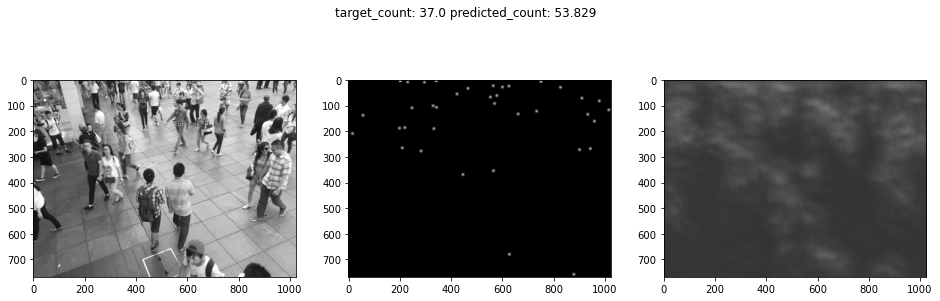

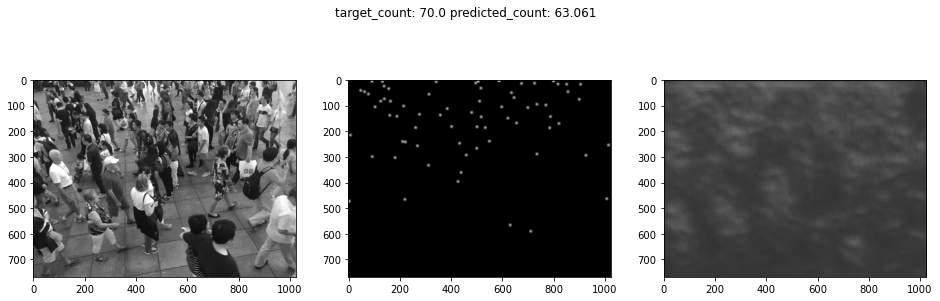

MAE: 54.457295989990214, RMSE: 71.33667646659813


In [18]:
def present_results(train_or_val_weights, tests_num=5):
    model = load_model(eval(f'weights_{train_or_val_weights}_path'), custom_objects=custom_objects)

    images = test_img[:tests_num]
    labels = test_labels[:tests_num]

    target_counts, target_dms = get_counts(labels), labels
    predicted_counts, predicted_dms = predict_counts(model, images, True)

    for image, target_count, target_dm, predicted_count, predicted_dm in zip(images, target_counts, target_dms, predicted_counts, predicted_dms):
        plot_prediction(image, target_count, target_dm, predicted_count, predicted_dm)

    mae, rmse = get_mae_rmse(target_counts, predicted_counts)
    print(f'MAE: {mae}, RMSE: {rmse}')

present_results('val')

## Profiling (DS:Conv 3:1)

In [ ]:
flops = get_flops(weights_val_path, custom_objects)
print_flops(flops, model)

## Model definition (DS:Conv 1:1)

In [3]:
# Model definition

reload(SANetDS)

epochs = 200
batch_size = 5
model_name = 'sanet'
submodel_name = '1_1'


weights_val_path = os.path.join('weights', f'{model_name}_{submodel_name}_{dataset}_val.hdf5')
weights_train_path = os.path.join('weights', f'{model_name}_{submodel_name}_{dataset}_train.hdf5')
res_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{model_name}_{submodel_name}"

callbacks = [
    *create_weights_callbacks(weights_train_path, weights_val_path),
    create_tensorboard_callback(),
    create_early_stopping_callback()
]

custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse, 'ssim_eucli_loss': ssim_eucli_loss}

model = SANetDS.SANetDS(ds_to_conv=(1, 1), enable_in=False)
model.summary()
model._get_distribution_strategy = lambda: None
adam = Adam(lr=1e-4)

# ssim_eucli_loss or 'mean_squared_error'
model.compile(loss=ssim_eucli_loss, optimizer=adam,
              metrics=[monitor_mae, monitor_mse])

Model: "SANet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 8 16          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, None, None, 8 17          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 80          input_1[0][0]                    
______________________________________________________________________________________________

## Training (DS:Conv 1:1)

In [4]:
prepare_output_dirs()

In [5]:
def fit(model, epochs=epochs):
    history = model.fit(
        x=create_generator(train_img, train_labels, batch_size),
        steps_per_epoch=get_steps_per_epoch(train_img, train_labels, batch_size),
        epochs=epochs,
        validation_data=create_generator(validation_img, validation_labels, 1),
        validation_steps=get_steps_per_epoch(validation_img, validation_labels, 1),
        callbacks=callbacks
    )
    return history

modules_first_layer_indices = [1, 11, 27, 43, 58]
last_index = 77
assert last_index == len(model.layers)
modules_indices = modules_first_layer_indices + [last_index]

for i in range(len(modules_indices) - 1):
    for j in range(modules_indices[1], modules_indices[i]):
        model.layers[j].trainable = False
    for j in range(modules_indices[i], modules_indices[i+1]):
        model.layers[j].trainable = True
    for j in range(modules_indices[i+1], modules_indices[-1]):
        model.layers[j].trainable = False

    model.compile(loss=ssim_eucli_loss, optimizer=adam, metrics=[monitor_mae, monitor_mse])

    fit(model, 2)

for i in range(1, modules_indices[-1]):
    model.layers[i].trainable = True
model.compile(loss=ssim_eucli_loss, optimizer=adam, metrics=[monitor_mae, monitor_mse])
history = fit(model)

#model = load_model('D:\\inzynierka\\inzynierka\\weights\\sanet_base_B_train_43_70.hdf5', custom_objects=custom_objects)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 720 steps, validate for 400 steps
Epoch 1/2
719/720 [============================>.] - ETA: 0s - loss: 5.3056e-06 - monitor_mae: 44.4813 - monitor_mse: 0.2100
Epoch 00001: val_loss improved from inf to 0.00000, saving model to weights\sanet_1_1_B_val.hdf5

Epoch 00001: loss improved from inf to 0.00001, saving model to weights\sanet_1_1_B_train.hdf5
720/720 [==============================] - 139s 193ms/step - loss: 5.3063e-06 - monitor_mae: 44.4939 - monitor_mse: 0.2100 - val_loss: 3.9592e-06 - val_monitor_mae: 7.5416 - val_monitor_mse: 0.0296
Epoch 2/2
719/720 [============================>.] - ETA: 0s - loss: 5.3046e-06 - monitor_mae: 44.4812 - monitor_mse: 0.2099
Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to weights\sanet_1_1_B_val.hdf5

Epoch 00002: loss improved from 0.00001 to 0.00001, saving model to weights\sanet_1_1_B_train.hdf5
720/720 [==============================] - 127s 177ms/step - los

## Analyze training (DS:Conv 1:1)

In [ ]:
loss, val_loss = read_history(history)
plot_losses(loss, val_loss)
save_losses(loss, val_loss, res_name)
print(res_name)

## Test (DS:Conv 1:1)

In [8]:
def test_model(train_or_val):
    weights_path = eval(f'weights_{train_or_val}_path')

    model = load_model(weights_path, custom_objects=custom_objects)

    targets = get_counts(test_labels)
    predictions = predict_counts(model, test_img)

    mae, rmse = get_mae_rmse(targets, predictions)

    save_test_results(model, mae, rmse, res_name, train_or_val, weights_path)

    print(res_name + ' ' + train_or_val)
    print(f'MAE: {mae}, RMSE: {rmse}')

test_model('train')
test_model('val')

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:22<00:00,  3.83it/s]


2020-11-07_09-05-17_sanet_1_1 train
MAE: 69.90900308874589, RMSE: 109.28150457666285


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:22<00:00,  3.84it/s]

2020-11-07_09-05-17_sanet_1_1 val
MAE: 69.90900308874589, RMSE: 109.28150457666285


## Results presentation (DS:Conv 1:1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


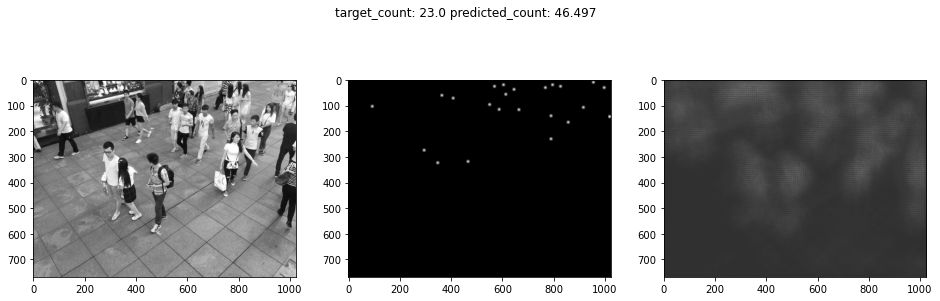

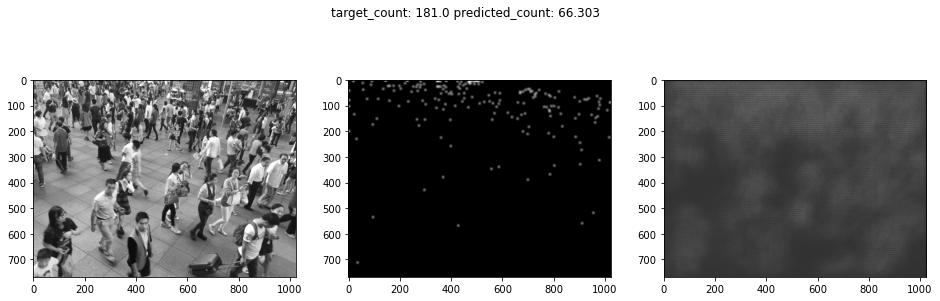

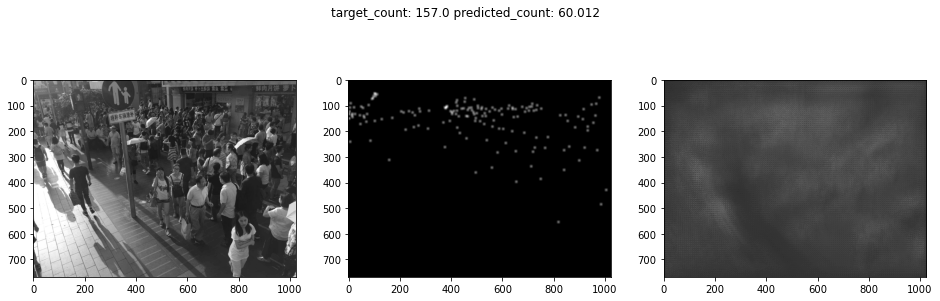

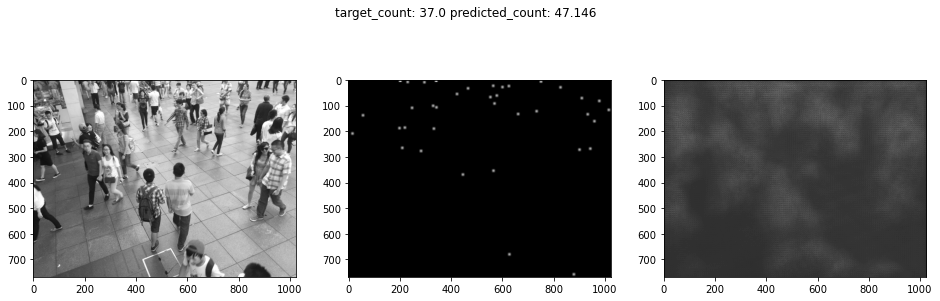

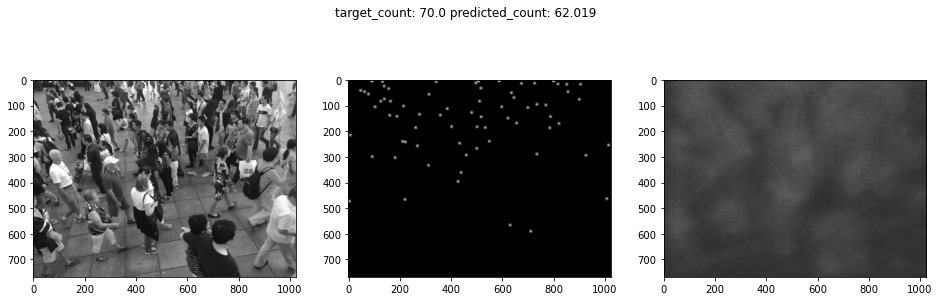

MAE: 50.66167221069334, RMSE: 68.23603126720018


In [7]:
def present_results(train_or_val_weights, tests_num=5):
    model = load_model(eval(f'weights_{train_or_val_weights}_path'), custom_objects=custom_objects)

    images = test_img[:tests_num]
    labels = test_labels[:tests_num]

    target_counts, target_dms = get_counts(labels), labels
    predicted_counts, predicted_dms = predict_counts(model, images, True)

    for image, target_count, target_dm, predicted_count, predicted_dm in zip(images, target_counts, target_dms, predicted_counts, predicted_dms):
        plot_prediction(image, target_count, target_dm, predicted_count, predicted_dm)

    mae, rmse = get_mae_rmse(target_counts, predicted_counts)
    print(f'MAE: {mae}, RMSE: {rmse}')

present_results('val')

## Profiling (DS:Conv 1:1)

In [ ]:
flops = get_flops(weights_val_path, custom_objects)
print_flops(flops, model)